In [16]:

# Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [17]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

In [20]:
df[df['artist'] == 'Rick Astley']

,artist,featured,aliases,title,track_id,explicit,release_year,lyrics,skip
5762,Rick Astley,NaN,"Rick, Astley",Never Gonna Give You Up,7GhIk7Il098yCjg4BQjzvb,False,1987,Were no strangers to love You know the rules a...,0
5763,Rick Astley,NaN,"Rick, Astley",Together Forever,6ZiVaOE4ikIsYbuhVHizz9,False,1987,If theres anything you need All you have to do...,0
5764,Rick Astley,NaN,"Rick, Astley",Dance,4mFtfh6vWW3tXyxAhDCt7h,False,2016,God walks home through the local park Meets th...,0
5765,Rick Astley,NaN,"Rick, Astley",Keep Singing,6TdHgARbMSVuftE4Lb0dHY,False,2016,When I was a boy I saw my daddy crying at the ...,0
5766,Rick Astley,NaN,"Rick, Astley",Angels On My Side,5EW05nJtJ9EcxDWPygONxV,False,2016,Sometimes I just dont feel like waking up Wann...,0
...,...,...,...,...,...,...,...,...,...
5854,Rick Astley,NaN,"Rick, Astley",Get Lucky,NaN,NaN,2001,"Like the legend of the phoenix, huh All ends w...",0
5855,Rick Astley,NaN,"Rick, Astley",Don’t Ask,5VsqWmwtPlQGE7cVfqgWrK,False,2001,I may not always show it But deep down dont yo...,0
5856,Rick Astley,NaN,"Rick, Astley",Breathe,2sMAAGQjuaFqscFCv5ReVD,False,2001,Paper towers of vogue and vanity fair They are...,0
5857,Rick Astley,NaN,"Rick, Astley",Full Of You,52SCOX2Imxh7heIu4KW8Wt,False,2001,Cardboard boxes on the floor They contain memo...,0


In [3]:
df["skip"].value_counts(normalize=True)

0    0.75993
1    0.24007
Name: skip, dtype: float64

There are some words that I don't want displayed on screen so I will replace them as 'vulgar', they can still help my model with it's predictions. These words are not so much easy predictors, as much as they are words that I don't feel comfortable being part of my visualizations or my publicly viewable project.

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

Train Test Split

In [6]:
X = df['lyrics']
y = df['skip']

In [7]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591,), (2864,), (8591,), (2864,))

In [10]:
def start_pipeline(vect, model, color, pipe_params):
    
    if vect == 'cv':
        instantiate_vect = CountVectorizer
        vect_name = 'CountVectorizer'
    elif vect == 'tvec':
        instantiate_vect = TfidfVectorizer
        vect_name = 'TfidfVectorizer'
        
    if model == 'Mnb':
        instantiate_model = MultinomialNB
        model_name = 'MultinomialNB'
    elif model == 'Bnb':
        instantiate_model = BernoulliNB
        model_name = 'BernoulliNB'
        
        
        #----- Pipeline-----#
    
    pipe = Pipeline([
    (vect , instantiate_vect(stop_words = 'english')), # transformer
    (model , instantiate_model()) # estimator
    ])

    # --- Gridsearch----#
    gs = GridSearchCV(pipe,
                 pipe_params, # defined outside of function for easy change
                 cv=5,
                 verbose = 1,
                 n_jobs=-1)
    
    
    gs.fit(X_train,y_train)
    preds = gs.predict(X_test)
    train_preds = gs.predict(X_train)
    
    #------ Scores & Params------- #
    print(f'Gridsearch best score is: {gs.best_score_}')
    print('')
    print(f'Gridsearch best params are: {gs.best_params_}')
    print('')
    print(f'{model_name} with {vect_name} Train Score :  {gs.score(X_train, y_train)*100:.2f}%')
    print(f'{model_name} with {vect_name}  Test Score  :  {gs.score(X_test, y_test)*100:.2f}%')
    print('')
    print(f'{model_name} with {vect_name}  F1- Train Score is {f1_score(y_train, train_preds)}')
    print(f'{model_name} with {vect_name}  F1- Test Score is F1-Score is {f1_score(y_test, preds)}')
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the words were predicted correctly by the model.")
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity is: {(tn / (tn + fp))*100:.2f}%")
    
    plot_confusion_matrix(gs, X_test, y_test, cmap= color);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.3min finished


Gridsearch best score is: 0.7893135069865591

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}

MultinomialNB with CountVectorizer Train Score :  81.74%
MultinomialNB with CountVectorizer  Test Score  :  79.05%

MultinomialNB with CountVectorizer  F1- Train Score is 0.6524916943521596
MultinomialNB with CountVectorizer  F1- Test Score is F1-Score is 0.6057818659658343

55.28% of the words were predicted correctly by the model.
The specificity is: 82.86%


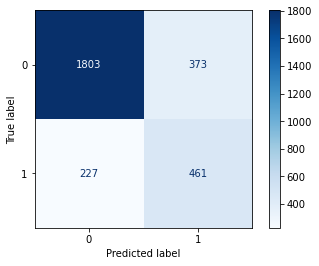

In [11]:
start_pipeline('cv', 'Mnb', 'Blues', pipe_params = {
                                'cv__max_features': [2_000, 4_500, 5_000, 5_500],
                                'cv__min_df' : [2,3], # ignore terms that show up less than 2 or 3 times in corpus
                                'cv__max_df' : [.5, .95], # ignore terms that show up either more than 50% or 95% of the corpus
                                'cv__ngram_range' : [(1,1), (1,2), (1,3)], # single words and bigrams
})

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.4min finished


Gridsearch best score is: 0.8072407882591403

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 6000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

MultinomialNB with TfidfVectorizer Train Score :  83.03%
MultinomialNB with TfidfVectorizer  Test Score  :  80.31%

MultinomialNB with TfidfVectorizer  F1- Train Score is 0.6130573248407644
MultinomialNB with TfidfVectorizer  F1- Test Score is F1-Score is 0.5451612903225806

61.23% of the words were predicted correctly by the model.
The specificity is: 90.17%


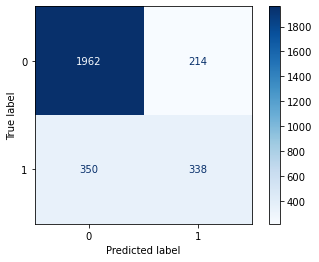

In [12]:

start_pipeline('tvec', 'Mnb', 'Blues', pipe_params = {
                                                        'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                        'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                        'tvec__min_df' : [2,3], 
                                                        'tvec__max_df' : [.5, .95]})

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.7min finished


Gridsearch best score is: 0.7968808516200163

Gridsearch best params are: {'Bnb__alpha': 0.275, 'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 2)}

BernoulliNB with CountVectorizer Train Score :  80.36%
BernoulliNB with CountVectorizer  Test Score  :  80.13%

BernoulliNB with CountVectorizer  F1- Train Score is 0.6552217453505007
BernoulliNB with CountVectorizer  F1- Test Score is F1-Score is 0.6524129505192425

56.27% of the words were predicted correctly by the model.
The specificity is: 80.93%


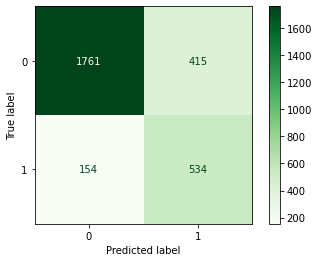

In [13]:
start_pipeline('cv', 'Bnb', 'Greens', pipe_params = {
                                                    'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                    'cv__max_features': [5_000, 5_500, 7_000, 9_000],
                                                    'cv__min_df' : [2,3],
                                                    'cv__max_df' : [.5, .95],
                                                    'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.8min finished


Gridsearch best score is: 0.7958330539793217

Gridsearch best params are: {'Bnb__alpha': 0.425, 'tvec__max_df': 0.5, 'tvec__max_features': 7000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

BernoulliNB with TfidfVectorizer Train Score :  80.24%
BernoulliNB with TfidfVectorizer  Test Score  :  80.24%

BernoulliNB with TfidfVectorizer  F1- Train Score is 0.654034229828851
BernoulliNB with TfidfVectorizer  F1- Test Score is F1-Score is 0.652760736196319

56.48% of the words were predicted correctly by the model.
The specificity is: 81.16%


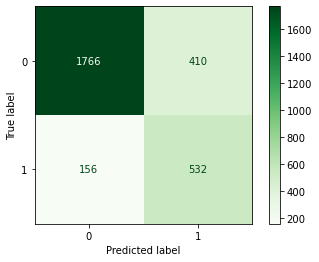

In [14]:
start_pipeline('tvec', 'Bnb', 'Greens', pipe_params = {
                                                'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                'tvec__min_df' : [2,3], 
                                                'tvec__max_df' : [.5, .95],
})